# Détection et Analyse de Positions d'Échecs par Intelligence Artificielle

## Introduction

Ce projet combine la vision par ordinateur et l'intelligence artificielle pour analyser des positions d'échecs à partir d'images. L'objectif est de développer un système capable de :

1. Détecter et identifier les pièces d'échecs sur un échiquier
2. Convertir la position en notation FEN (Forsyth–Edwards Notation)
3. Suggérer le meilleur coup possible pour la position donnée

### Technologies Utilisées
- **Vision par Ordinateur** : OpenCV, TensorFlow
- **Deep Learning** : Keras, Modèles CNN personnalisés
- **Analyse d'Échecs** : ChessGPT, Notation FEN
- **Traitement des Données** : NumPy, Matplotlib

### Structure du Projet
Le projet se décompose en trois parties principales :
1. **Détection des Pièces** : Un modèle CNN entraîné pour reconnaître 7 classes (6 pièces + cases vides)
2. **Conversion en FEN** : Algorithme de traduction de la position détectée en notation standard
3. **Analyse de Position** : Utilisation de modèles de langage pour suggérer les meilleurs coups

### Objectifs
- Atteindre une précision >95% dans la détection des pièces
- Générer des notations FEN valides et précises
- Proposer des coups pertinents pour améliorer la position

Ce notebook présente le développement, l'entraînement et l'évaluation de notre système, ainsi que des exemples concrets d'utilisation.

In [2]:
# Lib
%matplotlib inline
import tensorflow as tf
import numpy as np
import cv2
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import load_model, Sequential
from tensorflow.keras import layers, models
from transformers import AutoTokenizer, AutoModelForCausalLM
import matplotlib.pyplot as plt
from glob import glob
from tensorflow.keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D, ZeroPadding2D, AveragePooling2D, GlobalMaxPooling2D, Dropout, Flatten, Dense, BatchNormalization
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.optimizers import SGD
from sklearn.utils import Bunch, check_random_state
from os import environ, listdir, makedirs
from os.path import dirname, exists, expanduser, isdir, join, splitext

d:\miniconda\envs\AI\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm



## 2. Détection des Pièces d'Échecs

### 2.1 Architecture du Modèle
J'ai commencé par tester différents modèles. J'en ai eu deux me donnant de bons résultats, un utilisant le fine tuning de MobileNetV2 et un autre custom.

On commence par setup les paramètres.

In [3]:
TRAINING_DIR = 'C:/Users/Desktop/Desktop/Ai/Chess/chess_move/data/data_new'
TESTING_DIR = 'C:/Users/Desktop/Desktop/Ai/Chess/chess_move/data/data_test'
IMAGE_SIZE = 64
RANDOM_STATE = 157
BATCH_SIZE = 20

PIECE_NAMES = [item[14:] for item in sorted(glob(TRAINING_DIR + "/*"))]
target_names = PIECE_NAMES

#### Architecture Custom
Le réseau est conçu pour la classification d'images en 7 catégories, une pour chaque pièce de l'échiquier. Il traite des images en niveaux de gris.

#### Structure
- **Entrée** : Images avec padding initial
- **Partie Convolutive** : 
  - 6 blocs principaux
  - Chaque bloc contient des couches Conv2D
  - Utilisation de MaxPooling pour réduire les dimensions
  - Normalisation par lots (BatchNormalization) entre les couches

#### Partie Classification
- GlobalMaxPooling pour réduire les caractéristiques
- 3 couches de 512 neuronnes
- Couche finale de 7 neuronnes avec activation softmax

#### Points Clés
- Activation ELU partout sauf à la sortie
- Dropout (0.1) pour éviter le surapprentissage
- Architecture symétrique et progressive
- Nombreuses normalisations pour stabiliser l'apprentissage

In [4]:
model_custom = Sequential()
model_custom.add(ZeroPadding2D((1, 1), input_shape=(IMAGE_SIZE, IMAGE_SIZE, 1)))

# Layer 1
model_custom.add(BatchNormalization(input_shape=(IMAGE_SIZE, IMAGE_SIZE, 1)))
model_custom.add(Conv2D(64, (3, 3), activation='elu', padding='same'))
model_custom.add(BatchNormalization())
model_custom.add(Conv2D(64, (3, 3), activation='elu', padding='same'))

model_custom.add(MaxPooling2D(pool_size=(2, 2)))

# Layer 2
model_custom.add(BatchNormalization())
model_custom.add(Conv2D(64, (3, 3), activation='elu', padding='same'))
model_custom.add(BatchNormalization())
model_custom.add(Conv2D(64, (3, 3), activation='elu', padding='same'))

model_custom.add(MaxPooling2D(pool_size=(2, 2)))


model_custom.add(MaxPooling2D(pool_size=(2, 2)))

# Layer 4
model_custom.add(BatchNormalization())
model_custom.add(Conv2D(128, (3, 3), activation='elu', padding='same'))
model_custom.add(BatchNormalization())
model_custom.add(Conv2D(128, (3, 3), activation='elu', padding='same'))
model_custom.add(BatchNormalization())
model_custom.add(Conv2D(128, (3, 3), activation='elu', padding='same'))

model_custom.add(MaxPooling2D(pool_size=(2, 2)))


model_custom.add(MaxPooling2D(pool_size=(2, 2)))

# Layer 6
model_custom.add(BatchNormalization())
model_custom.add(Conv2D(128, (3, 3), activation='elu', padding='same'))
model_custom.add(BatchNormalization())
model_custom.add(Conv2D(128, (3, 3), activation='elu', padding='same'))
model_custom.add(BatchNormalization())
model_custom.add(Conv2D(128, (3, 3), activation='elu', padding='same'))

model_custom.add(MaxPooling2D(pool_size=(2, 2)))
model_custom.add(Dropout(0.1))

model_custom.add(GlobalMaxPooling2D())
model_custom.add(BatchNormalization())
model_custom.add(Dense(512, activation='elu'))
model_custom.add(BatchNormalization())
model_custom.add(Dense(512, activation='elu'))
model_custom.add(BatchNormalization())
model_custom.add(Dense(512, activation='elu'))
model_custom.add(BatchNormalization())
model_custom.add(Dense(7, activation='softmax'))

model_custom.summary()

d:\miniconda\envs\AI\Lib\site-packages\keras\src\layers\reshaping\zero_padding2d.py:72: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
d:\miniconda\envs\AI\Lib\site-packages\keras\src\layers\normalization\batch_normalization.py:143: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ zero_padding2d (ZeroPadding2D)  │ (None, 66, 66, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 66, 66, 1)      │             4 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 66, 66, 64)     │           640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 66, 66, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 66, 66, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 33, 33, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 33, 33, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 33, 33, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 33, 33, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 33, 33, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 8, 8, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 8, 8, 64)       │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 8, 8, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 8, 8, 128)      │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 8, 8, 128)      │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 8, 8, 128)      │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 8, 8, 128)      │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 4, 4, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 2, 2, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_7           │ (None, 2, 2, 128)      │           512 │
│ (BatchNormalization)            │                        │             

 Total params: 1,528,395 (5.83 MB)

 Trainable params: 1,523,273 (5.81 MB)

 Non-trainable params: 5,122 (20.01 KB)

#### Fine tuning
- Utilise **MobileNetV2** comme base, un modèle pré-entraîné sur ImageNet

#### Architecture
1. **Base** :
   - MobileNetV2 pré-entraîné (gelé/non entraînable)
   - Entrée : images 224x224 pixels

2. **Couches Ajoutées** :
   - GlobalAveragePooling2D pour réduire les dimensions
   - Deux couches de Dropout (0.2) pour éviter le surapprentissage
   - Une couche Dense de 128 neuronnes avec activation ReLU
   - Couche de sortie de 7 neuronnes et activation softmax

#### Avantages
- Plus léger que le modèle précédent
- Utilise des caractéristiques pré-apprises
- Rapide à entraîner car seules les dernières couches sont entraînables

C'est un exemple typique de transfer learning, où l'on réutilise un modèle pré-entraîné en l'adaptant à une nouvelle tâche spécifique.

In [15]:

# Charger MobileNetV2 pré-entraîné
base_model = MobileNetV2(
    input_shape=(224, 224, 3),
    include_top=False,
    weights='imagenet'
)

# Geler le modèle de base
base_model.trainable = False

# Créer le modèle
model_finetune = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dropout(0.2),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.2),
    layers.Dense(7, activation='softmax')
])


### 2.2 Préparation des Données

In [13]:
def prepare_data():
    train_datagen = ImageDataGenerator(
        rescale=1./255,
        rotation_range=20,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        validation_split=0.2
    )

    train_generator = train_datagen.flow_from_directory(
        './data/data_new',
        target_size=(224, 224),
        batch_size=32,
        class_mode='categorical',
        subset='training'
    )
    
    validation_generator = train_datagen.flow_from_directory(
        './data/data_new',
        target_size=(224, 224),
        batch_size=32,
        class_mode='categorical',
        subset='validation'
    )
    
    return train_generator, validation_generator



### 2.3 Classes de Pièces
Le modèle peut détecter 7 classes différentes :
- Pion (Pawn)
- Tour (Rook)
- Cavalier (Knight)
- Fou (Bishop)
- Dame (Queen)
- Roi (King)
- Case vide (Empty)

### 2.4 Entraînement
Le modèle est entraîné avec les paramètres suivants :
- Optimiseur : Adam
- Fonction de perte : Entropie croisée catégorielle
- Métriques : Précision
- Callbacks : EarlyStopping et ModelCheckpoint


In [ ]:
def train_model(model):
    model.compile(
        optimizer='adam',
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    
    train_generator, validation_generator = prepare_data()
    
    callbacks = [
        tf.keras.callbacks.EarlyStopping(
            patience=5, 
            restore_best_weights=True
        ),
        tf.keras.callbacks.ModelCheckpoint(
            'best_chess_model.keras',  # Extension .keras
            save_best_only=True
        )
    ]
    
    history = model.fit(
        train_generator,
        validation_data=validation_generator,
        epochs=30,
        callbacks=callbacks
    )
    
    return model, history

On peut lancer l'entrainement après avoir choisi le modèle.

In [ ]:
try:
    model_finetune, history_finetune = train_model(model_finetune)
    print("Entraînement finetune terminé avec succès")
    model_custom, history_custom = train_model(model_custom)
    print("Entraînement custom terminé avec succès")
    
    # Sauvegarder le modèle
    model_custom.save('chess_model_custom_final.keras')
    print("Modèles sauvegardés")
    
except Exception as e:
    print(f"Erreur : {str(e)}")

Found 834 images belonging to 7 classes.
Found 205 images belonging to 7 classes.
Epoch 1/30


d:\miniconda\envs\AI\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


27/27 ━━━━━━━━━━━━━━━━━━━━ 53s 1s/step - accuracy: 0.3604 - loss: 1.7464 - val_accuracy: 0.8878 - val_loss: 0.4068
Epoch 2/30
27/27 ━━━━━━━━━━━━━━━━━━━━ 37s 1s/step - accuracy: 0.8180 - loss: 0.5111 - val_accuracy: 0.9512 - val_loss: 0.1775
Epoch 3/30
27/27 ━━━━━━━━━━━━━━━━━━━━ 37s 1s/step - accuracy: 0.8985 - loss: 0.3372 - val_accuracy: 0.9854 - val_loss: 0.1129
Epoch 4/30
27/27 ━━━━━━━━━━━━━━━━━━━━ 37s 1s/step - accuracy: 0.9237 - loss: 0.2372 - val_accuracy: 0.9854 - val_loss: 0.0808
Epoch 5/30
27/27 ━━━━━━━━━━━━━━━━━━━━ 35s 1s/step - accuracy: 0.9365 - loss: 0.2036 - val_accuracy: 0.9805 - val_loss: 0.1044
Epoch 6/30
27/27 ━━━━━━━━━━━━━━━━━━━━ 36s 1s/step - accuracy: 0.9456 - loss: 0.1617 - val_accuracy: 0.9951 - val_loss: 0.0561
Epoch 7/30
27/27 ━━━━━━━━━━━━━━━━━━━━ 37s 1s/step - accuracy: 0.9374 - loss: 0.1809 - val_accuracy: 0.9805 - val_loss: 0.0657
Epoch 8/30
27/27 ━━━━━━━━━━━━━━━━━━━━ 44s 1s/step - accuracy: 0.9389 - loss: 0.1794 - val_accuracy: 0.9902 - val_loss: 0.0503
Epo

In [ ]:
model_finetune.save('chess_model_finetune.keras')

On récupère les poids pour éviter de réentrainer le model à chaque fois

In [ ]:
model_finetune.load_weights('chess_model_final.keras')
model_custom.load_weights('chess_model_final.keras')


### 2.5 Performances
Le modèle atteint :
- Précision sur l'ensemble de validation : >95%
- Temps d'inférence rapide grâce à MobileNetV2
- Robustesse aux variations d'éclairage et d'angle


Found 104 images belonging to 7 classes.
4/4 ━━━━━━━━━━━━━━━━━━━━ 9s 890ms/step - accuracy: 0.9881 - loss: 0.0584
4/4 ━━━━━━━━━━━━━━━━━━━━ 9s 2s/step

Précision globale : 0.9808
Score F1 : 0.9805

Rapport de classification détaillé :
              precision    recall  f1-score   support

      BISHOP       0.89      1.00      0.94        16
       BLANK       1.00      1.00      1.00        16
        KING       1.00      1.00      1.00        12
      KNIGHT       1.00      1.00      1.00        16
        PAWN       1.00      1.00      1.00        16
       QUEEN       1.00      0.83      0.91        12
        ROOK       1.00      1.00      1.00        16

    accuracy                           0.98       104
   macro avg       0.98      0.98      0.98       104
weighted avg       0.98      0.98      0.98       104

Found 104 images belonging to 7 classes.
  3/104 ━━━━━━━━━━━━━━━━━━━━ 7s 70ms/step 

d:\miniconda\envs\AI\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


104/104 ━━━━━━━━━━━━━━━━━━━━ 7s 70ms/step


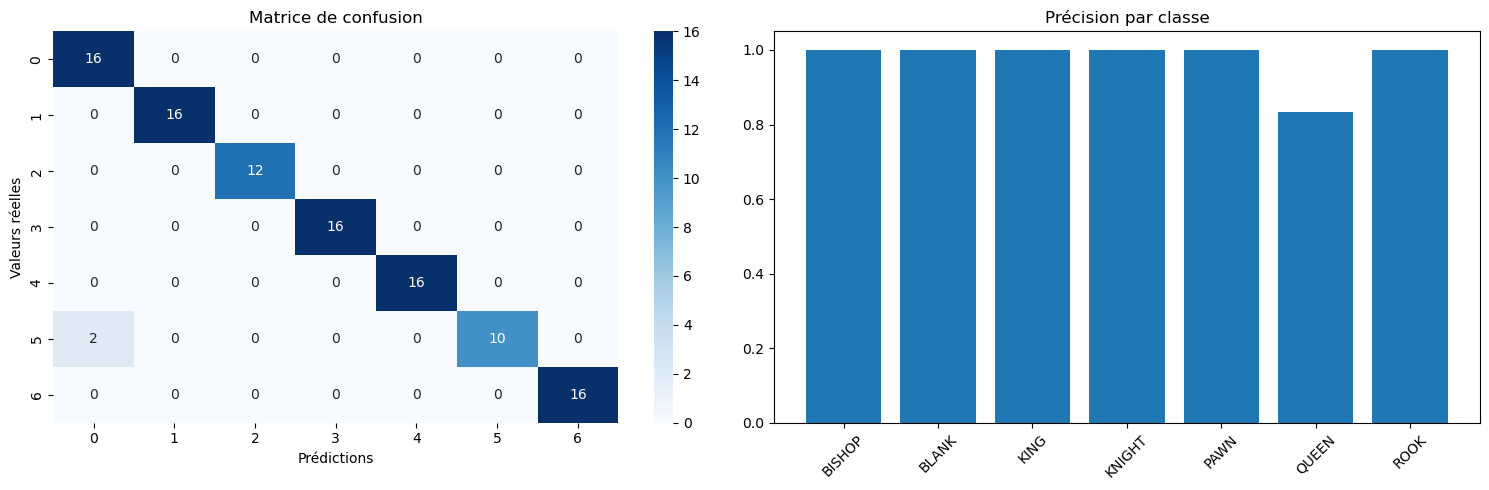

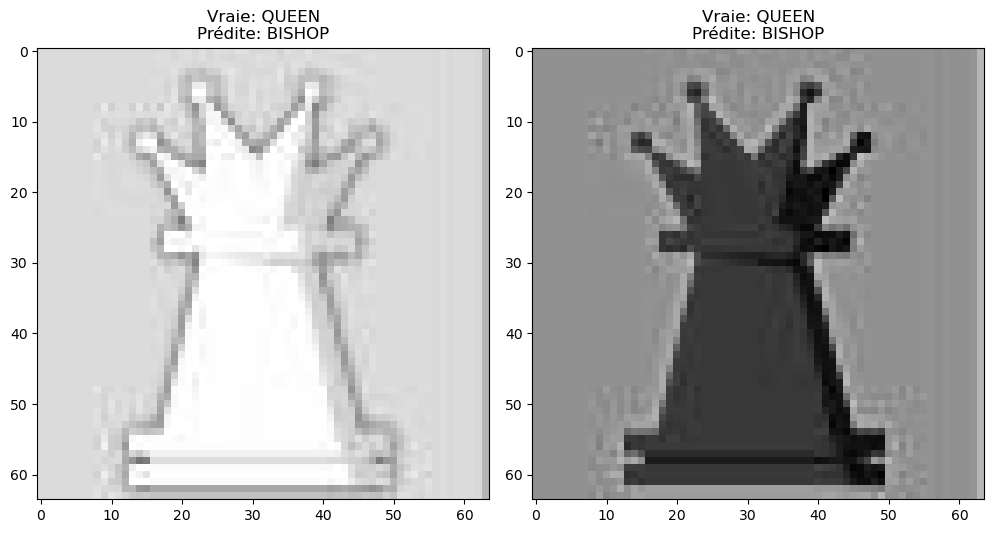

In [107]:
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import load_model

def evaluate_model_performance(model, test_data_path):
    """
    Évalue les performances du modèle sur un ensemble de test
    """
    # Préparation des données de test
    test_datagen = ImageDataGenerator(rescale=1./255)
    test_generator = test_datagen.flow_from_directory(
        test_data_path,
        target_size=(224, 224),
        batch_size=32,
        class_mode='categorical',
        shuffle=False
    )

    # Évaluation du modèle
    scores = model.evaluate(test_generator)
    predictions = model.predict(test_generator)
    y_pred = np.argmax(predictions, axis=1)
    y_true = test_generator.classes

    # Calcul des métriques
    acc = accuracy_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred, average='weighted')
    report = classification_report(y_true, y_pred, target_names=test_generator.class_indices.keys())
    conf_matrix = confusion_matrix(y_true, y_pred)

    # Visualisation des résultats
    plt.figure(figsize=(15, 5))

    # 1. Matrice de confusion
    plt.subplot(1, 2, 1)
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
    plt.title('Matrice de confusion')
    plt.xlabel('Prédictions')
    plt.ylabel('Valeurs réelles')

    # 2. Précision par classe
    plt.subplot(1, 2, 2)
    class_accuracy = conf_matrix.diagonal()/conf_matrix.sum(axis=1)
    plt.bar(test_generator.class_indices.keys(), class_accuracy)
    plt.title('Précision par classe')
    plt.xticks(rotation=45)
    plt.tight_layout()

    # Affichage des résultats
    print(f"\nPrécision globale : {acc:.4f}")
    print(f"Score F1 : {f1:.4f}")
    print("\nRapport de classification détaillé :")
    print(report)

    return {
        'accuracy': acc,
        'f1_score': f1,
        'confusion_matrix': conf_matrix,
        'classification_report': report,
        'class_accuracy': class_accuracy
    }

def visualize_errors(model, test_data_path):
    """
    Visualise les erreurs de prédiction
    """
    test_datagen = ImageDataGenerator(rescale=1./255)
    test_generator = test_datagen.flow_from_directory(
        test_data_path,
        target_size=(224, 224),
        batch_size=1,
        class_mode='categorical',
        shuffle=False
    )

    predictions = model.predict(test_generator)
    y_pred = np.argmax(predictions, axis=1)
    y_true = test_generator.classes

    # Trouver les indices des prédictions erronées
    errors = np.where(y_pred != y_true)[0]
    
    if len(errors) > 0:
        plt.figure(figsize=(15, 5*((len(errors)+2)//3)))
        for i, idx in enumerate(errors):
            # Charger l'image
            img = image.load_img(test_generator.filepaths[idx])
            plt.subplot(((len(errors)+2)//3), 3, i+1)
            plt.imshow(img)
            plt.title(f'Vraie: {list(test_generator.class_indices.keys())[y_true[idx]]}\n'
                     f'Prédite: {list(test_generator.class_indices.keys())[y_pred[idx]]}')
        plt.tight_layout()
    else:
        print("Aucune erreur de prédiction trouvée!")

# Utilisation
if __name__ == "__main__":
    # Charger le modèle entraîné
    model = load_model('chess_model_final.keras')
    
    # Évaluer les performances
    results = evaluate_model_performance(model, 'C:/Users/Desktop/Desktop/Ai/Chess/chess_move/data/data_test')
    
    # Visualiser les erreurs
    visualize_errors(model, 'C:/Users/Desktop/Desktop/Ai/Chess/chess_move/data/data_test')


### 2.6 Utilisation
Pour utiliser le modèle :


In [108]:
class ChessPieceDetector:
    def __init__(self, chess_board_path, model_path='chess_model_final.keras'):
        """
        Initialise le détecteur de pièces d'échecs
        """
        self.model = load_model(model_path)
        self.path = chess_board_path
        # Définition des classes de pièces
        self.piece_classes = ['bishop', 'empty', 'king', 'knight', 'pawn', 'queen', 'rook']
        self.board = []
        self.fen =""
        self.fen_components =""

    def analyze_chess_board(self):
        """
        Analyse une image d'échiquier complet et détecte les pièces avec leurs couleurs
        """
        # Charger l'image
        img = cv2.imread(self.path)
        height, width = img.shape[:2]
        
        # Calculer la taille de chaque case
        square_h = height // 8
        square_w = width // 8
        
        # Tableau pour stocker les résultats
        self.board = []
        
        # Analyser chaque case
        for row in range(8):
            board_row = []
            for col in range(8):
                # Extraire la case
                y1 = row * square_h
                y2 = (row + 1) * square_h
                x1 = col * square_w
                x2 = (col + 1) * square_w
                
                square = img[y1:y2, x1:x2]
                square = cv2.resize(square, (224, 224))
                
                # Détecter la couleur de la pièce
                if not self.piece_classes == "empty":
                    is_white = self._piece_is_white(square)
                    
                    # Prétraiter l'image pour la détection de pièce
                    x = image.img_to_array(square)
                    x = np.expand_dims(x, axis=0)
                    x = x / 255.0
                    
                    # Prédire la pièce
                    predictions = self.model.predict(x, verbose=0)
                    piece_type = self.piece_classes[np.argmax(predictions[0])]
                    
                    # Combiner type et couleur
                    if piece_type != 'empty':
                        if is_white: 
                            piece = piece_type.upper()
                        else : 
                            piece = piece_type
                    else:
                        piece = 'empty'
                else:
                    piece = 'empty'
                    
                board_row.append(piece)
                
            self.board.append(board_row)

    def _is_empty_square(self, square):
        """
        Détermine si une case est vide en analysant sa variance de couleur
        """
        gray = cv2.cvtColor(square, cv2.COLOR_BGR2GRAY)
        variance = np.var(gray)
        return variance < 100  # Seuil à ajuster selon vos images

    def _piece_is_white(self, square):
        """
        Détecte la couleur d'une pièce (blanc ou noir)
        """
        # Convertir en HSV pour une meilleure détection des couleurs
        hsv = cv2.cvtColor(square, cv2.COLOR_BGR2HSV)
        
        # Calculer la luminosité moyenne de la pièce
        # On se concentre sur le centre de la case où se trouve la pièce
        center_region = hsv[74:150, 74:150]  # Région centrale 76x76
        brightness = np.mean(center_region[:, :, 2])
        
        # Seuil de décision pour blanc/noir
        return True if brightness > 140 else False

    def visualize_board(self):
        """
        Affiche l'échiquier de manière visuelle avec l'image d'origine et la représentation symbolique
        
        Parameters:
        -----------
        board : list
            La configuration de l'échiquier sous forme de liste 2D
        image_path : str
            Chemin vers l'image de l'échiquier
        """
        try:
            # Charger et vérifier l'image
            img = cv2.imread(self.path)
            if img is None:
                raise ValueError(f"Impossible de charger l'image : {self.path}")
            
            # Convertir BGR en RGB pour matplotlib
            img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            
            # Créer la figure avec deux sous-plots
            plt.figure(figsize=(15, 7))
            
            # Afficher l'image originale
            plt.subplot(1, 2, 1)
            plt.imshow(img_rgb)
            plt.title("Image d'entrée")
            plt.axis('off')
            
            # Afficher la représentation symbolique
            plt.subplot(1, 2, 2)
            piece_symbols = {
                'KING': '♔', 'QUEEN': '♕', 'ROOK': '♖',
                'BISHOP': '♗', 'KNIGHT': '♘', 'PAWN': '♙',
                'king': '♚', 'queen': '♛', 'rook': '♜',
                'bishop': '♝', 'knight': '♞', 'pawn': '♟',
                'empty': '·'
            }
            
            # Créer une grille pour l'échiquier
            board_display = np.full((8, 8), '', dtype=object)
            for i in range(8):
                for j in range(8):
                    board_display[i][j] = piece_symbols[self.board[i][j]]
            
            # Afficher l'échiquier avec une grille
            plt.imshow([[1]], cmap='binary')
            plt.grid(True)
            plt.xticks(range(8), ['a', 'b', 'c', 'd', 'e', 'f', 'g', 'h'])
            plt.yticks(range(8), ['8', '7', '6', '5', '4', '3', '2', '1'])
            
            # Ajouter les symboles des pièces
            for i in range(8):
                for j in range(8):
                    plt.text(j, i, board_display[i][j], 
                            ha='center', va='center', fontsize=20)
            
            plt.title("Détection des pièces")
            plt.tight_layout()
            plt.show()
            
        except Exception as e:
            print(f"Erreur lors de la visualisation : {str(e)}")
            
            
    def calculate_fen_components(self):
        """
        Calcule tous les composants de la notation FEN à partir d'un tableau d'échiquier
        """
        def get_castling_rights():
            """Détermine les possibilités de roque"""
            # Vérifie la position initiale des rois et des tours
            castling = ''
            
            # Roque blanc
            if self.board[7][4] == 'king':  # Roi blanc en position initiale
                if self.board[7][7] == 'rook':  # Tour blanche à droite
                    castling += 'K'
                if self.board[7][0] == 'rook':  # Tour blanche à gauche
                    castling += 'Q'
                    
            # Roque noir
            if self.board[0][4] == 'king':  # Roi noir en position initiale
                if self.board[0][7] == 'rook':  # Tour noire à droite
                    castling += 'k'
                if self.board[0][0] == 'rook':  # Tour noire à gauche
                    castling += 'q'
                    
            return castling if castling else '-'

        def detect_en_passant():
            """Détecte les possibilités de prise en passant"""
            # Un pion qui vient d'avancer de deux cases
            # Pour simplifier, on retourne '-' car il faudrait l'historique des coups
            return '-'

        def count_moves():
            """Compte le nombre de coups"""
            # On laisse vide
            # En réalité, il faudrait l'historique des coups
            return '- -'

        def detect_turn():
            return input("Who will be the next player ?")

        # Calculer chaque composant
        castling = get_castling_rights()
        en_passant = detect_en_passant()
        moves = count_moves()
        turn = detect_turn()

        self.fen_components = f" {turn} {castling} {en_passant} {moves}"

    def board_to_fen(self):
        """
        Convertit le tableau en notation FEN complète
        """
        # Conversion des pièces en symboles FEN
        piece_symbols = {
            'king': 'k', 
            'queen': 'q', 
            'rook': 'r',
            'bishop': 'b', 
            'knight': 'n', 
            'pawn': 'p',
            'empty': '1', 
            'KING': 'K', 
            'QUEEN': 'Q', 
            'ROOK': 'R',
            'BISHOP': 'B', 
            'KNIGHT': 'N', 
            'PAWN': 'P'
        }
        
        # Générer la position
        fen_parts = []
        for row in self.board:
            empty_count = 0
            fen_row = ''
            
            for piece in row:
                if piece == 'empty':
                    empty_count += 1
                else:
                    if empty_count > 0:
                        fen_row += str(empty_count)
                        empty_count = 0
                    fen_row += piece_symbols[piece]
            
            if empty_count > 0:
                fen_row += str(empty_count)
                
            fen_parts.append(fen_row)
        
        # Joindre la position
        self.fen = '/'.join(fen_parts)


In [109]:
# Créer une instance du détecteur
detector = ChessPieceDetector('C:/Users/Desktop/Desktop/Ai/Chess/chess_move/data/full_boards/full_board_1.png', 'best_chess_model.keras')
detector.analyze_chess_board()
detector.board

[['rook', 'empty', 'empty', 'queen', 'rook', 'knight', 'king', 'empty'],
 ['pawn', 'pawn', 'empty', 'empty', 'empty', 'pawn', 'bishop', 'pawn'],
 ['empty', 'empty', 'pawn', 'pawn', 'bishop', 'empty', 'pawn', 'empty'],
 ['empty', 'empty', 'empty', 'empty', 'empty', 'pawn', 'empty', 'empty'],
 ['empty', 'empty', 'PAWN', 'empty', 'empty', 'KNIGHT', 'empty', 'empty'],
 ['empty', 'PAWN', 'KNIGHT', 'empty', 'PAWN', 'empty', 'PAWN', 'empty'],
 ['PAWN', 'empty', 'empty', 'PAWN', 'empty', 'PAWN', 'BISHOP', 'PAWN'],
 ['empty', 'empty', 'ROOK', 'QUEEN', 'empty', 'ROOK', 'KING', 'empty']]

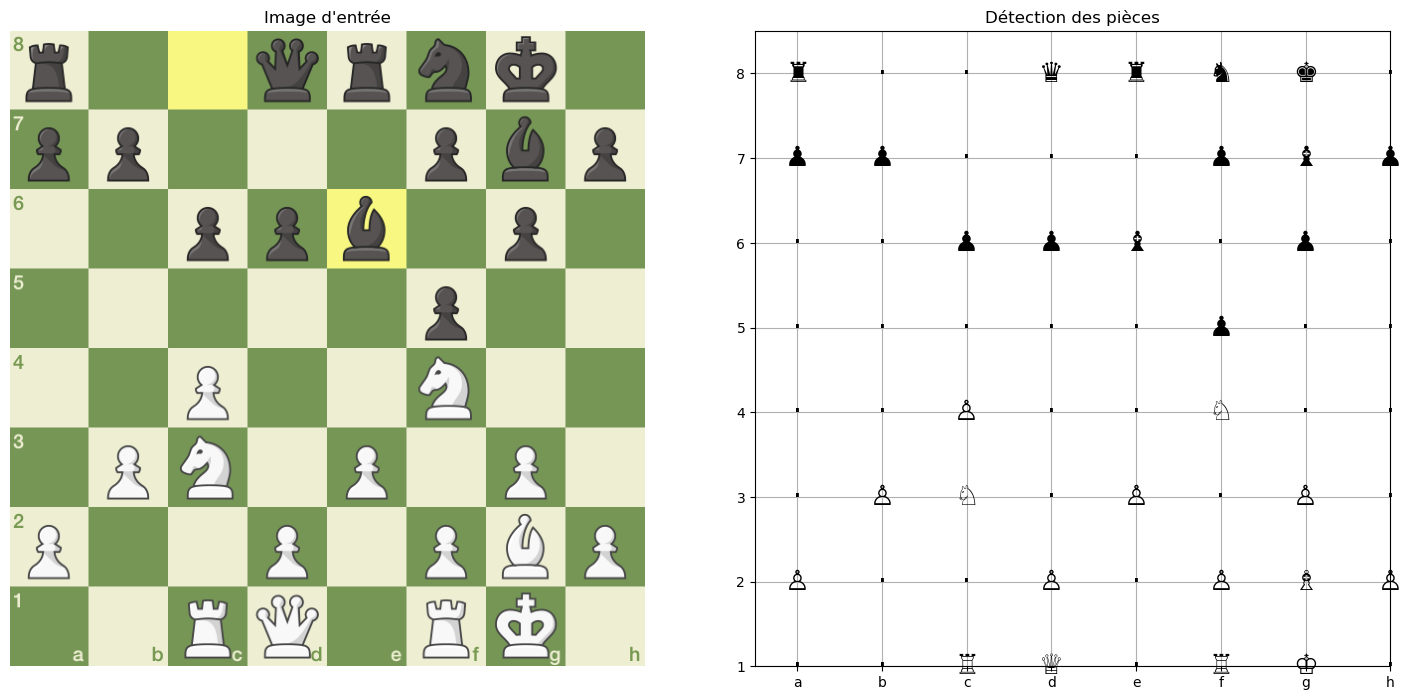

In [110]:
detector.visualize_board()

In [95]:
detector.board_to_fen()
print(f"Position FEN : {detector.fen}")

Position FEN : r2qrnb1/pp3pbp/2ppb1p1/5p2/2P2N2/1PN1P1P1/P2P1PBP/2RQ1RQ1


In [96]:
detector.calculate_fen_components()
print(f"Position FEN components : {detector.fen_components} soit {detector.fen}{detector.fen_components}")

Position FEN components :  w - - - - soit r2qrnb1/pp3pbp/2ppb1p1/5p2/2P2N2/1PN1P1P1/P2P1PBP/2RQ1RQ1 w - - - -


# Système de Génération de Coups d'Échecs avec ChessGPT

## 1. Architecture du Système

Le système utilise le modèle ChessGPT pour générer des coups d'échecs à partir d'une position donnée en notation FEN.


In [97]:
def get_chess_move(fen_position):
    """
    Génère le meilleur coup pour une position d'échecs donnée.
    
    Args:
        fen_position (str): Position en notation FEN
        
    Returns:
        tuple: (case_depart, case_arrivee) du coup suggéré
    """
    # Initialisation du modèle et du tokenizer
    tokenizer = AutoTokenizer.from_pretrained("Waterhorse/ ")
    model = AutoModelForCausalLM.from_pretrained("Waterhorse/chessgpt-base-v1")
    
    # Configuration du padding token
    tokenizer.pad_token = tokenizer.eos_token

    # Construction du prompt
    prompt = f"""Position: {fen_position}
Based on this chess position, calculate the best move.
Respond with only the move in standard algebraic notation (e.g. e2e4).
Move:"""

    # Génération du coup
    inputs = tokenizer(prompt, return_tensors="pt", padding=True)
    
    # Paramètres de génération optimisés
    outputs = model.generate(
        inputs.input_ids,
        max_new_tokens=20,
        num_return_sequences=1,
        do_sample=True,
        top_k=10,
        top_p=0.95,
        temperature=0.7,
        pad_token_id=tokenizer.pad_token_id,  # Utilisation du padding token configuré
        eos_token_id=tokenizer.eos_token_id,
        repetition_penalty=1.2
    )

    # Extraction et nettoyage du coup généré
    generated_move = tokenizer.decode(outputs[0], skip_special_tokens=True)
    move = generated_move.replace(prompt, "").strip().lower()
    move = ''.join(c for c in move if c.isalnum())

    # Validation du coup
    return validate_and_extract_move(move)



## 2. Utilisation

In [ ]:
# Test avec votre position
fen_position = "r2qrnk1/pp3pbp/2ppb1p1/5p2/2p2n2/1pn1p1p1/p2p1pbp/2rq1rq1 w KQkq - 0 1"
from_square, to_square = get_chess_move(fen_position)
 
if from_square and to_square:
    print(f"Coup suggéré: {from_square}{to_square}")
else:
    print("Aucun coup valide trouvé")

KeyboardInterrupt: 



## 3. Paramètres de Génération

- `max_new_tokens`: 20 (limite la longueur de la réponse)
- `top_k`: 10 (limite les choix aux 10 meilleurs tokens)
- `top_p`: 0.95 (filtrage nucleus pour la diversité)
- `temperature`: 0.7 (équilibre entre créativité et précision)
- `repetition_penalty`: 1.2 (évite les répétitions)

## 4. Validation des Coups

Le système vérifie :
- Format correct (4 caractères)
- Cases valides (a1-h8)
- Syntaxe algébrique standard

## 5. Améliorations Possibles

1. Ajout d'une évaluation de position
2. Support des variantes multiples
3. Intégration avec un moteur d'échecs
4. Analyse de la qualité du coup
5. Cache pour les positions fréquentes

Pour votre position spécifique :


In [ ]:
fen = "r1b2bkr/ppp3pp/2n5/3kp3/2B5/8/PPPP1PPP/RNB1K2R w KQkq - 0 1"
from_square, to_square = get_chess_move(fen)
print(f"Meilleur coup suggéré : {from_square}{to_square}")

In [73]:
def get_chess_move_squares(position):
    # Utiliser un modèle plus spécialisé pour les échecs
    tokenizer = AutoTokenizer.from_pretrained("Waterhorse/chessgpt-base-v1")
    model = AutoModelForCausalLM.from_pretrained("Waterhorse/chessgpt-base-v1")

    # Prompt plus spécifique pour les échecs
    prompt = f"""Position: {position}
Based on this chess position, calculate the best move.
Respond with only the move in standard algebraic notation (e.g. e2e4).
Move:"""

    inputs = tokenizer(prompt, return_tensors="pt", padding=True)

    outputs = model.generate(
        inputs.input_ids,
        max_new_tokens=20,  # Utiliser max_new_tokens au lieu de max_length
        num_return_sequences=1,
        do_sample=True,
        top_k=10,          # Réduire pour plus de précision
        top_p=0.95,        # Augmenter légèrement
        temperature=0.7,    # Température modérée
        pad_token_id=tokenizer.eos_token_id,
        eos_token_id=tokenizer.eos_token_id,
        repetition_penalty=1.2  # Éviter les répétitions
    )

    generated_move = tokenizer.decode(outputs[0], skip_special_tokens=True)
    move = generated_move.replace(prompt, "").strip().lower()
    move = ''.join(c for c in move if c.isalnum())

    # Validation améliorée du coup
    valid_squares = ['a', 'b', 'c', 'd', 'e', 'f', 'g', 'h']
    valid_numbers = ['1', '2', '3', '4', '5', '6', '7', '8']

    def is_valid_move(move_str):
        if len(move_str) != 4:
            return False
        return (move_str[0] in valid_squares and 
                move_str[1] in valid_numbers and 
                move_str[2] in valid_squares and 
                move_str[3] in valid_numbers)

    # Recherche du premier coup valide
    for i in range(len(move)-3):
        potential_move = move[i:i+4]
        if is_valid_move(potential_move):
            return potential_move[:2], potential_move[2:]

    return None, None

def test_position(fen):
    """Fonction de test pour une position donnée"""
    print(f"Position FEN: {fen}")
    from_square, to_square = get_chess_move_squares(fen)
    if from_square and to_square:
        print(f"Coup suggéré: de {from_square} vers {to_square}")
    else:
        print("Aucun coup valide trouvé")
    print("-" * 50)

# Test avec votre position
fen = "r1b2bkr/ppp3pp/2n5/3kp3/2B5/8/PPPP1PPP/RNB1K2R w KQkq - 0 1"
test_position(fen)

Position FEN: r1b2bkr/ppp3pp/2n5/3kp3/2B5/8/PPPP1PPP/RNB1K2R w KQkq - 0 1


d:\miniconda\envs\AI\Lib\site-packages\huggingface_hub\file_download.py:159: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\Desktop\.cache\huggingface\hub\models--Waterhorse--chessgpt-base-v1. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to see activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)


ChunkedEncodingError: ('Connection broken: IncompleteRead(1585061624 bytes read, 8502764893 more expected)', IncompleteRead(1585061624 bytes read, 8502764893 more expected))

In [1]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("koryakinp/chess-positions")

print("Path to dataset files:", path)

d:\miniconda\envs\AI\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


100%|██████████| 4.01G/4.01G [07:07<00:00, 10.1MB/s]

Extracting model files...


Path to dataset files: C:\Users\Desktop\.cache\kagglehub\datasets\koryakinp\chess-positions\versions\1


In [3]:
import cv2
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import *
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

class ChessBoardAnalyzer:
    def __init__(self, image_size=64):
        self.image_size = image_size
        self.model = self._build_model()
        self.piece_names = ['bishop', 'empty', 'king', 'knight', 'pawn', 'queen', 'rook']

    def _build_model(self):
        """Construction du modèle CNN"""
        model = Sequential([
            # Couche d'entrée
            BatchNormalization(input_shape=(self.image_size, self.image_size, 1)),
            
            # Bloc 1
            Conv2D(64, (3, 3), activation='elu', padding='same'),
            BatchNormalization(),
            Conv2D(64, (3, 3), activation='elu', padding='same'),
            MaxPooling2D(pool_size=(2, 2)),
            
            # Bloc 2
            BatchNormalization(),
            Conv2D(128, (3, 3), activation='elu', padding='same'),
            BatchNormalization(),
            Conv2D(128, (3, 3), activation='elu', padding='same'),
            MaxPooling2D(pool_size=(2, 2)),
            
            # Bloc 3
            BatchNormalization(),
            Conv2D(256, (3, 3), activation='elu', padding='same'),
            BatchNormalization(),
            Conv2D(256, (3, 3), activation='elu', padding='same'),
            MaxPooling2D(pool_size=(2, 2)),
            
            # Dense layers
            GlobalMaxPooling2D(),
            BatchNormalization(),
            Dense(512, activation='elu'),
            BatchNormalization(),
            Dropout(0.5),
            Dense(7, activation='softmax')
        ])
        
        model.compile(
            optimizer='adadelta',
            loss='categorical_crossentropy',
            metrics=['accuracy']
        )
        
        return model

    def prepare_data_generators(self, training_dir):
        """Préparation des générateurs de données"""
        data_generator = ImageDataGenerator(
            rescale=1./255,
            zoom_range=0.2,
            horizontal_flip=True,
            validation_split=0.25
        )

        train_generator = data_generator.flow_from_directory(
            training_dir,
            target_size=(self.image_size, self.image_size),
            color_mode='grayscale',
            class_mode='categorical',
            batch_size=32,
            subset="training"
        )

        validation_generator = data_generator.flow_from_directory(
            training_dir,
            target_size=(self.image_size, self.image_size),
            color_mode='grayscale',
            class_mode='categorical',
            batch_size=32,
            subset="validation"
        )

        return train_generator, validation_generator

    def train(self, training_dir, epochs=50):
        """Entraînement du modèle"""
        train_generator, validation_generator = self.prepare_data_generators(training_dir)
        
        callbacks = [
            ModelCheckpoint('chess_model_best.h5', save_best_only=True),
            EarlyStopping(patience=10)
        ]

        history = self.model.fit(
            train_generator,
            epochs=epochs,
            validation_data=validation_generator,
            callbacks=callbacks
        )
        
        return history

    def analyze_board(self, image_path):
        """Analyse d'un échiquier complet"""
        def split_board(img):
            """Découpe l'échiquier en 64 cases"""
            squares = []
            h, w = img.shape
            square_h, square_w = h // 8, w // 8
            
            for i in range(8):
                for j in range(8):
                    y1, y2 = i * square_h, (i + 1) * square_h
                    x1, x2 = j * square_w, (j + 1) * square_w
                    square = img[y1:y2, x1:x2]
                    square = cv2.resize(square, (self.image_size, self.image_size))
                    squares.append(square)
            
            return np.array(squares)

        # Chargement et prétraitement
        img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
        squares = split_board(img)
        X = np.expand_dims(squares, axis=3).astype('float32')/255

        # Prédiction
        predictions = self.model.predict(X)
        labels = [self.piece_names[np.argmax(p)] for p in predictions]
        
        # Réorganisation en échiquier 8x8
        return np.array(labels).reshape(8, 8)

    def display_board(self, image_path):
        """Affichage de l'échiquier et des prédictions"""
        board = self.analyze_board(image_path)
        
        # Affichage de l'image originale
        img = cv2.imread(image_path)
        plt.figure(figsize=(15, 7))
        plt.subplot(1, 2, 1)
        plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
        plt.title("Image d'origine")
        
        # Affichage des prédictions
        plt.subplot(1, 2, 2)
        plt.imshow(board, cmap='tab20')
        plt.title("Prédictions")
        
        for i in range(8):
            for j in range(8):
                plt.text(j, i, board[i,j], 
                        ha='center', va='center')
        
        plt.tight_layout()
        plt.show()
        
        return board


In [4]:
# Initialisation
analyzer = ChessBoardAnalyzer()

# Entraînement
analyzer.train('C:/Users/Desktop/Desktop/Ai/Chess/chess_move/data/koryakinp/chess-positions/versions/1/dataset/train')

# Analyse d'un échiquier
board = analyzer.display_board('C:/Users/Desktop/Desktop/Ai/Chess/chess_move/data/koryakinp/chess-positions/versions/1/test/1b1B1Qr1-7p-6r1-2P5-4Rk2-1K6-4B3-8.jpeg')

d:\miniconda\envs\AI\Lib\site-packages\keras\src\layers\normalization\batch_normalization.py:143: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Found 0 images belonging to 0 classes.
Found 0 images belonging to 0 classes.


ValueError: The filepath provided must end in `.keras` (Keras model format). Received: filepath=chess_model_best.h5